In [43]:
from glob import glob
import json
import os
import requests

import pandas as pd
from pandas.io.json import json_normalize
from sqlalchemy import create_engine
from tqdm import tqdm

%matplotlib inline

In [24]:
eng = create_engine('sqlite:///db/data.sqlite3', echo=False)

In [26]:
# !mkdir images
# !mkdir data
# !mkdir db

mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘db’: File exists


## Get image data

In [29]:
# !wget -o data/data.json http://beyondwords.labs.loc.gov/data

In [2]:
# data downloaded from http://beyondwords.labs.loc.gov/#/
with open('data/data.json') as jsonfile:
    data = json.load(jsonfile)['data']

In [3]:
data[:2]

[{'id': '5b58d934536f120001000899',
  'location': {'standard': 'http://s3.amazonaws.com/ndnp-jpeg-surrogates/iune_edition_ver02/data/sn92053934/00295872640/1917051101/0140.jpg'},
  'region': {'toolName': 'rectangleTool',
   'color': '#fe0000',
   'x': 894.7970970281847,
   'y': 476.34528054483155,
   'width': 814.6840109640661,
   'height': 1504.716867515449,
   'label': 'Illustration/Photo'},
  'width': 6064,
  'height': 7615,
  'meta_data': {'set_key': 'http://chroniclingamerica.loc.gov/lccn/sn92053934/1917-05-11/ed-1/seq-11/',
   'subject_url': 'http://chroniclingamerica.loc.gov/lccn/sn92053934/1917-05-11/ed-1/seq-11/',
   'subject_description': 'Rock Island Argus. May 11, 1917. Page 11',
   'resize': '1.000000',
   'alto': 'http://s3.amazonaws.com/ndnp-batches/iune_edition_ver02/data/sn92053934/00295872640/1917051101/0140.xml'},
  'data': {'caption': 'TAKES OLD POST IN ROCK ISLAND AGAIN\nGeneral Alexander Mackenzie.',
   'category': 'Photograph'}},
 {'id': '5b281840d6342b0001001ade

In [4]:
# the json data contains some inconsistencies: sometimes 
# the 'data' attribute is sometimes at root level, somtimes
# nested in a single-item list (under a 'values' attribute)

# move 'data' attribute to root if necessary
for i, doc in enumerate(data):
    values_attrib = doc['data'].get('values')
    if values_attrib: 
        data[i]['data'] = values_attrib[0]

In [5]:
# flatten the data, create dataframe
df = json_normalize(data)
# json_normalize uses periods in col names; change to underscore
df.columns = df.columns.map(lambda x: x.replace('.', '_'))

df.head(3)

,data_caption,data_category,data_creator,height,id,location_standard,meta_data_alto,meta_data_resize,meta_data_set_key,meta_data_subject_description,meta_data_subject_url,region_color,region_height,region_label,region_toolName,region_width,region_x,region_y,width
0,TAKES OLD POST IN ROCK ISLAND AGAIN\nGeneral A...,Photograph,NaN,7615,5b58d934536f120001000899,http://s3.amazonaws.com/ndnp-jpeg-surrogates/i...,http://s3.amazonaws.com/ndnp-batches/iune_edit...,1.000000,http://chroniclingamerica.loc.gov/lccn/sn92053...,"Rock Island Argus. May 11, 1917. Page 11",http://chroniclingamerica.loc.gov/lccn/sn92053...,#fe0000,1504.716868,Illustration/Photo,rectangleTool,814.684011,894.797097,476.345281,6064
1,CHARLES W. DYSON\nCharles W Dyson is one of th...,Photograph,HARRIS & EWING,6752,5b281840d6342b0001001ade,http://s3.amazonaws.com/ndnp-jpeg-surrogates/i...,http://s3.amazonaws.com/ndnp-batches/idhi_elio...,1.000000,http://chroniclingamerica.loc.gov/lccn/sn86091...,"The Idaho recorder. January 25, 1918. Page 6",http://chroniclingamerica.loc.gov/lccn/sn86091...,#fe0000,1708.444852,Illustration/Photo,rectangleTool,731.516481,3067.632009,4294.709435,4592
2,MAJ. HAROLD E. HARTLEY\nMaj. Harold Evans Hart...,Photograph,International Film Service,6680,5b281742d6342b0001001adc,http://s3.amazonaws.com/ndnp-jpeg-surrogates/i...,http://s3.amazonaws.com/ndnp-batches/idhi_elio...,1.000000,http://chroniclingamerica.loc.gov/lccn/sn88056...,"The Challis messenger. October 30, 1918. Page 2",http://chroniclingamerica.loc.gov/lccn/sn88056...,#fe0000,1515.405322,Illustration/Photo,rectangleTool,689.619195,2301.653205,4221.172506,4432


In [6]:
# drop columns we probably won't need
drop_cols = [
    'meta_data_resize',
    'region_color',
    'region_toolName',
    'region_label',
]
for col in drop_cols:
    df.drop(col, axis=1, inplace=True)

In [7]:
# show data types that pandas has inferred
df.dtypes

data_caption                      object
data_category                     object
data_creator                      object
height                             int64
id                                object
location_standard                 object
meta_data_alto                    object
meta_data_set_key                 object
meta_data_subject_description     object
meta_data_subject_url             object
region_height                    float64
region_width                     float64
region_x                         float64
region_y                         float64
width                              int64
dtype: object

In [8]:
df.count()

data_caption                     1488
data_category                    1489
data_creator                      431
height                           1503
id                               1503
location_standard                1503
meta_data_alto                   1503
meta_data_set_key                1503
meta_data_subject_description    1503
meta_data_subject_url            1503
region_height                    1503
region_width                     1503
region_x                         1503
region_y                         1503
width                            1503
dtype: int64

In [9]:
# convert NaNs to blanks in text columns that have missing columns
na_blank_cols = ['data_caption', 'data_category', 'data_creator']
for col in na_blank_cols:
    df[col] = df[col].fillna('')


In [10]:
# add a column that is an md5 hash of the image url,
# we'll use this as an image identifier

import hashlib

# func to return hash for a string
def hashstr(s):
    return hashlib.md5(s.encode('utf8')).hexdigest()

# apply to new column
df['img_url_hash'] = df.apply(lambda r: hashstr(r['location_standard']), axis = 1)

In [21]:
# save data as sqlite db
df.to_sql('data', eng, index=False, if_exists='replace')

In [22]:
# re-read data from sql and check data types
pd.read_sql("select * from data", eng).dtypes

data_caption                      object
data_category                     object
data_creator                      object
height                             int64
id                                object
location_standard                 object
meta_data_alto                    object
meta_data_set_key                 object
meta_data_subject_description     object
meta_data_subject_url             object
region_height                    float64
region_width                     float64
region_x                         float64
region_y                         float64
width                              int64
img_url_hash                      object
dtype: object

In [23]:
# re-read data from sql and check counts
pd.read_sql("select * from data", eng).count()

data_caption                     1503
data_category                    1503
data_creator                     1503
height                           1503
id                               1503
location_standard                1503
meta_data_alto                   1503
meta_data_set_key                1503
meta_data_subject_description    1503
meta_data_subject_url            1503
region_height                    1503
region_width                     1503
region_x                         1503
region_y                         1503
width                            1503
img_url_hash                     1503
dtype: int64

## Get image Files

In [44]:
sql = "select location_standard, img_url_hash from data"
result = eng.execute(sql)
for row in tqdm(result):
    uhash = row[1]
    url = row[0]
    # image filename is based on url hash
    path = 'images/{}.jpg'.format(uhash)
    # skip if we've already downloaded this file
    if os.path.exists(path):
        continue
    # otherwise, download and save it
    else:
        r = requests.get(url, stream=True)
        # if http error, skip and print error
        if not r.status_code == 200:
            print('{} error for {}'.format(r.status_code, url))
            continue
        else:
            with open(path, 'wb') as f:
                for chunk in r:
                    f.write(chunk)

1503it [00:00, 109361.58it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00ee416dd8>]], dtype=object)

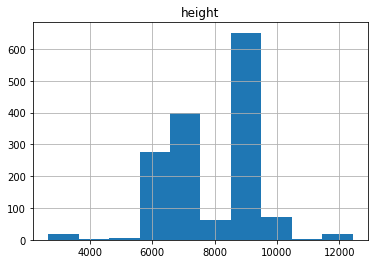

In [16]:
df.hist(column='height')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00ee49af98>]], dtype=object)

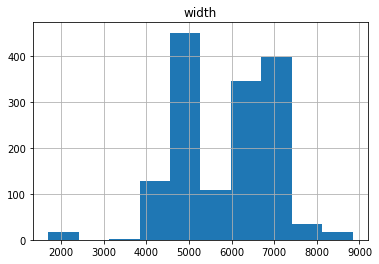

In [15]:
df.hist(column='width')